<div style="border:solid orange 3px; padding: 16px">  
    <font size="4">  
        <p style="text-align: center;">
            <b> 12. Прогнозы и предсказания. Прогнозирование оттока и кластеризация посетителей фитнес-центра </b>
        </p> 
    </font>
</div>

<a id="contents"></a>
### Оглавление:
0. [Описание проекта](#0)
1. [Предобработка данных](#1)
2. [Исследовательский анализ](#2)
3. [Модель прогнозирования оттока посетителей](#3)
4. [Кластеризация посетителей](#4)
5. [Выводы и рекомендации](#5)

 <a id="0"></a>
### 0. Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с посетителями на основе данных.
Задача — провести анализ клиентских анкет и подготовить план действий по удержанию клиентов.
А именно:
 - используя алгоритмы МО, научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
 - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
 - проанализировать основные признаки, наиболее сильно влияющие на отток;
 - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    -  выделить целевые группы клиентов;
    -  предложить меры по снижению оттока;
    -  определить другие особенности взаимодействия с клиентами.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

path = 'C:/Users/pavel/Desktop/da/projects/datasets/'

<a id="1"></a>
### 1. Предобработка данных  


In [2]:
# таблица df (данные о пользователях на месяц до оттока и факт оттока на определённый месяц)
df = pd.read_csv(path + '12_gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Данные о пользователях на месяц до оттока и факт оттока на определённый месяц:
- `Churn` — факт оттока в текущем месяце;
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба;
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» ;
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев или год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

Проведем предобработку данных.

In [3]:
# переименуем столбцы
df = df.rename(columns = {"gender" : "Gender"})

In [4]:
# выведем общую информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
Gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропусков в данных нет. Всего 4000 записей.

In [5]:
# количество полных дубликатов
df.duplicated().sum()

0

Отсутствуют полные дубликаты.

In [6]:
# для каждого столбца выведем уникальные записи и их количество 
for col in df.columns:
    print(df[col].value_counts())

1    2041
0    1959
Name: Gender, dtype: int64
1    3381
0     619
Name: Near_Location, dtype: int64
0    2053
1    1947
Name: Partner, dtype: int64
0    2766
1    1234
Name: Promo_friends, dtype: int64
1    3614
0     386
Name: Phone, dtype: int64
1     2207
12     960
6      833
Name: Contract_period, dtype: int64
0    2351
1    1649
Name: Group_visits, dtype: int64
29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: Age, dtype: int64
135.756722    1
97.623617     1
82.487277     1
17.911351     1
74.882931     1
             ..
163.080276    1
133.640108    1
9.838696      1
134.699410    1
357.046942    1
Name: Avg_additional_charges_total, Length: 4000, dtype: int64
1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0   

Видим, что значения в столбцах `Churn`, `Gender`, `Near_Location`, `Partner`, `Promo_friends`, `Phone`, `Group_visits` принимают только значения 0 или 1.
Значения в столбце `Month_to_end_contract` принимают только целые значения. 

In [7]:
# приведем данные в столбце 'Month_to_end_contract' к целочисленному типу
df.Month_to_end_contract = df.Month_to_end_contract.astype('int')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
Gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null int32
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(3), int32(1), int64(10)
memory usage: 422.0 KB


<a id="2"></a>
### 2. Исследовательский анализ  [*(Оглавление)*](#contents)


In [9]:
# зададим функцию для отображения значений на графиках 
def _show_values_on_bars(ax, space = 0.4, decimal = 0):
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + float(space)
        if decimal == 0:
            value = int(p.get_height())
        else:
            value = round(p.get_height(), decimal)
        ax.text(_x, _y, value, ha = "center")

Расмотрим распределение количества посетителей с разными признаками.

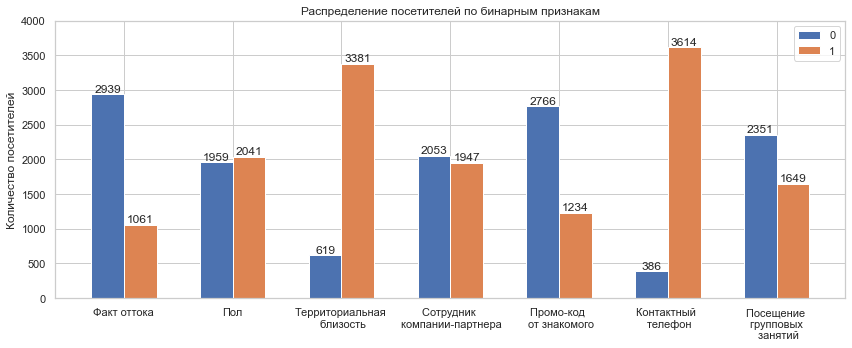

In [10]:
sns.set(style="whitegrid")

# зададим название признаков
labels = ['Факт оттока', 'Пол', 'Территориальная \n близость', 'Сотрудник \n компании-партнера', 
          'Промо-код \n от знакомого', 'Контактный \n телефон', 'Посещение \n групповых \n занятий']

# вычислим количество посетителей с 0 в бинарном признаке
zeros = [len(df.query('Churn == 0')), len(df.query('Gender == 0')), 
         len(df.query('Near_Location == 0')),len(df.query('Partner == 0')), 
         len(df.query('Promo_friends == 0')), len(df.query('Phone == 0')),
         len(df.query('Group_visits == 0'))]

# вычислим количество посетителей с 1 в бинарном признаке
units = [len(df.query('Churn == 1')), len(df.query('Gender == 1')), 
         len(df.query('Near_Location == 1')), len(df.query('Partner == 1')), 
         len(df.query('Promo_friends == 1')), len(df.query('Phone == 1')),
         len(df.query('Group_visits == 1'))]

# зададим вектор для размещения признаков на графике 
x = np.arange(len(labels))  

# ширина столбцов
width = 0.3  


fig, ax = plt.subplots(figsize=(12, 5))

rects1 = ax.bar(x - width/2, zeros, width, label='0')
rects2 = ax.bar(x + width/2, units, width, label='1')
_show_values_on_bars(ax, 30, 0)
# ax.grid(axis='y', color='.8')
# ax.set_axisbelow(True)

ax.set_ylim(0,4000)
ax.set_ylabel('Количество посетителей')
ax.set_title('Распределение посетителей по бинарным признакам')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation = 0, horizontalalignment = 'center')

ax.legend()
plt.tight_layout()

- В представленных данных около 26% пользователей ушли из фитнес-центра в текущем месяце. 
- Распределение по полу примерно одинаковое. 
- Для большинства посетителей фитнес-центр находится рядом с домом или работой. 
- Примерно половина посетителей работают в компании, которая сотрудничает с фитнес-центром. 
- Около трети пришло по рекомендации знакомых. 
- Примерно 10% посетителей не оставило свой контактный телефон.
- 40% всех посетителей посещали групповые занятия.

---

In [ ]:
# построим столбчатые диаграммы количества посетителей с разными признаками, которые ушли и остались
sns.set(style="whitegrid")

f, axes = plt.subplots(3, 2, figsize=(12, 11), sharex = True)

sns.countplot(x="Churn", hue = "Gender", data=df, ax=axes[0, 0])
sns.countplot(x="Churn", hue = "Near_Location", data=df, ax=axes[0, 1])
sns.countplot(x="Churn", hue = "Partner", data=df, ax=axes[1, 0])
sns.countplot(x="Churn", hue = "Promo_friends", data=df, ax=axes[1, 1])
sns.countplot(x="Churn", hue = "Phone", data=df, ax=axes[2, 0])
sns.countplot(x="Churn", hue = "Group_visits", data=df, ax=axes[2, 1])

for row in range(len(axes)):
    for col in range(len(axes[0])):
        _show_values_on_bars(axes[row, col], 20, 0)
        ylim = .000001
        for p in axes[row, col].patches:
            if p.get_height() > ylim:
                ylim =  p.get_height()
        axes[row, col].set_ylim(0, ylim*1.15)

axes[0, 0].set(xlabel = 'Факт оттока', ylabel = 'Количество посетителей')  
axes[0, 0].legend(title='Пол', loc='upper right')
axes[0, 1].set(xlabel = 'Факт оттока', ylabel = 'Количество посетителей')
axes[0, 1].legend(title='Территориальная \n близость', loc='upper right')
axes[1, 0].set(xlabel = 'Факт оттока', ylabel = 'Количество посетителей')
axes[1, 0].legend(title='Сотрудник \n компании-партнера', loc='upper right')
axes[1, 1].set(xlabel = 'Факт оттока', ylabel = 'Количество посетителей')
axes[1, 1].legend(title='Промо-код \n от знакомого', loc='upper right')
axes[2, 0].set(xlabel = 'Факт оттока', ylabel = 'Количество посетителей')
axes[2, 0].legend(title='Контактный \n телефон', loc='upper right')
axes[2, 1].set(xlabel = 'Факт оттока', ylabel = 'Количество посетителей')
axes[2, 1].legend(title='Посещение \n групповых занятий', loc='upper right')
f.suptitle('Распределение ушедших и оставшихся посетителей по бинарным признакам',
           fontsize=16)

plt.tight_layout()
f.subplots_adjust(top=0.93)

Рассмотрим распределение 

Распределения по большинству бинарных признаков носит похожий характер для оставшихся и ушедших пользователей. 
- Среди ушедших пользователей ниже доля тех, кто работает в компании-партнере фитнес центра (35% среди ушедших, 53% среди оставшихся). 
- Среди ушедших пользователей ниже доля тех, кто пришел по рекомендации от знакомых (18% среди ушедших, 35% среди оставшихся).
- Среди ушедших пользователей ниже доля тех, кто посещал групповые занятия (28% среди ушедших, 46% среди оставшихся).

---

In [ ]:
# гистограмма распределения возраста посетителей
f, ax = plt.subplots(figsize=(12, 5))
sns.histplot(df['Age'], kde = False)
ax.set(xlabel = 'Возраст', ylabel = 'Количество посетителей', 
       title = 'Распределение возраста посетителей')
plt.tight_layout()

print('Количественные характеристики распределения возраста посетителей:')
print()
print(df['Age'].describe().round(1))

Средний возраст посетителей фитнес-центра: 29 лет. Стандартное отклонение: 3 года.

In [ ]:
# гистограммы распределения возраста ушедших и оставшихся посетителей
f, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df.query('Churn == 0')['Age'], bins = 24, label = 'Оставшиеся посетители')
sns.distplot(df.query('Churn == 1')['Age'], bins = 24, label = 'Ушедшие посетители')

ax.set(xlabel = 'Возраст', ylabel = 'Плотность (KDE)', 
       title = 'Распределение возраста ушедших и оставшихся посетителей')
ax.legend()
plt.tight_layout()

print('Медианный возраст оставшихся посетителей:',df.query('Churn == 0')['Age'].median())
print('Медианный возраст ушедших посетителей:',df.query('Churn == 1')['Age'].median())

Средний возраст ушедших в этом месяце посетителей на 3 года меньше среднего возраста оставшихся (27 лет против 30).

---

In [ ]:
# гистограмма распределения длительности пользования фитнес-центром
f, ax = plt.subplots(figsize=(12, 5))
sns.histplot(df['Lifetime'], kde = False)
ax.set(xlabel = 'Длительность пользования фитнес-центром, мес.', 
       ylabel = 'Количество посетителей', 
       title = 'Распределение длительности пользования фитнес-центром')
plt.tight_layout()

print('Количественные характеристики распределения длительности пользования фитнес-центром (мес.):')
print()
print(df['Lifetime'].describe().round(2))

В среднем посетители пользуются фитнес-центром от 1 до 5 месяцев.

In [ ]:
# гистограммы распределения длительности пользования фитнес-центром ушедших и оставшихся посетителей
f, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df.query('Churn == 0')['Lifetime'], label = 'Оставшиеся посетители')
sns.distplot(df.query('Churn == 1')['Lifetime'], label = 'Ушедшие посетители')

ax.set(xlabel = 'Длительность пользования фитнес-центром, мес.', ylabel = 'Плотность (KDE)', 
       title = 'Распределение длительности пользования фитнес-центром ушедших и оставшихся посетителей)',
       xlim = (0, 12))
ax.legend()
plt.tight_layout()

print('Медианная длительность пользования оставшихся посетителей:', 
      df.query('Churn == 0')['Lifetime'].median(), 'мес.')
print('Медианная длительность пользования ушедших посетителей:', 
      df.query('Churn == 1')['Lifetime'].median(), 'мес.')

In [ ]:
# рассмотрим уникальные значения длительности пользования у ушедших пользователей
df.query('Churn == 1')['Lifetime'].value_counts()

Видим, что посетители уходят из фитнес-центра по большей части в первый-второй, иногда третий месяц после первого обращения.

---

In [ ]:
# гистограмма распределения длительности действующего абонемента
f, ax = plt.subplots(figsize=(12, 5))
sns.histplot(df['Contract_period'], kde = False)
ax.set(xlabel = 'Длительность действующего абонемента, (мес.)', 
       ylabel = 'Количество посетителей', 
       title = 'Распределение длительности действующего абонемента')
plt.tight_layout()

print('Количественные характеристики распределения длительности действующего абонемента (мес.):')
print()
print(df['Contract_period'].describe().round(2))

Более чем у половины посетителей длительность абонемента - 1 месяц.

In [ ]:
# гистограммы распределения длительности действующего абонемента у ушедших и оставшихся посетителей
f, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df.query('Churn == 0')['Contract_period'], label = 'Оставшиеся посетители')
sns.distplot(df.query('Churn == 1')['Contract_period'], label = 'Ушедшие посетители')

ax.set(xlabel = 'Длительность действующего абонемента, мес.', 
       ylabel = 'Плотность (KDE)', 
       title = 'Распределение длительности действующего абонемента ушедших и оставшихся посетителей')
ax.legend()
plt.tight_layout()

print('Медианная длительность действующего абонемента оставшихся посетителей:', 
      df.query('Churn == 0')['Contract_period'].median(), 'мес.')
print('Медианная длительность действующего абонемента ушедших посетителей:', 
      df.query('Churn == 1')['Contract_period'].median(), 'мес.')

In [ ]:
# рассмотрим уникальные значения длительности пользования у ушедших пользователей
df.query('Churn == 1')['Contract_period'].value_counts()

У оставшихся посетителей средняя длительность абонемента - 6 месяцев. У 88% ушедших пользователей длительность абонемента - 1 месяц. 

---

In [ ]:
# гистограмма распределения срока до окончания действия текущего абонемента
f, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df['Month_to_end_contract'], kde = False)
ax.set(xlabel = 'Срок до окончания действующего абонемента, мес.', 
       ylabel = 'Количество посетителей', 
       title = 'Распределение срока до окончания действия текущего абонемента')
plt.tight_layout()

print('Количественные характеристики распределения срока до окончания действия текущего абонемента (мес.):')
print()
print(df['Month_to_end_contract'].describe().round(2))

Более чем у половины посетителей срок до окончания действия текущего абонемента - 1 месяц, это связано с тем, что более чем у половины пользователей абонемент и был на 1 месяц.

In [ ]:
# гистограммы распределения срока до окончания действующего абонемента у ушедших и оставшихся посетителей
f, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df.query('Churn == 0')['Month_to_end_contract'], label = 'Оставшиеся посетители')
sns.distplot(df.query('Churn == 1')['Month_to_end_contract'], label = 'Ушедшие посетители')

ax.set(xlabel = 'Срок до окончания действия текущего абонемента, (мес.)', 
       ylabel = 'Плотность (KDE)', 
       title = 'Распределение срока до окончания действия текущего абонемента ушедших и оставшихся посетителей')
ax.legend()
plt.tight_layout()

print('Медианный срок до окончания действия текущего абонемента оставшихся посетителей:', 
      df.query('Churn == 0')['Month_to_end_contract'].median(), 'мес.')

print('Медианный срок до окончания действия текущего абонемента ушедших посетителей:', 
      df.query('Churn == 1')['Month_to_end_contract'].median(), 'мес.')

In [ ]:
# рассмотрим уникальные значения срока до окончания действия текущего абонемента у ушедших пользователей
df.query('Churn == 1')['Month_to_end_contract'].value_counts()

У оставшихся посетителей средний срок до окончания действия текущего абонемента - 6 месяцев. У большинста ушедших пользователей срок до окончания действия текущего абонемента - 1 месяц. Распределение похоже на распределение для длительности действия абонемента.

---

In [ ]:
# гистограмма распределения средней частоты посещений в неделю (за все время)
f, ax = plt.subplots(figsize=(12, 5))
sns.histplot(df['Avg_class_frequency_total'], kde = False)
ax.set(xlabel = 'Средняя частота посещений в неделю (за все время)', 
       ylabel = 'Количество посетителей', 
       title = 'Распределение средней частоты посещений в неделю (за все время)')
plt.tight_layout()

print('Количественные характеристики распределения средней частоты посещений в неделю (за все время):')
print()
print(df['Avg_class_frequency_total'].describe().round(2))

В среднем посетители бывают в фитнес-центре 1-3 раза в неделю.

In [ ]:
# гистограммы распределения средней частоты посещений в неделю (за все время) у ушедших и оставшихся посетителей
f, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df.query('Churn == 0')['Avg_class_frequency_total'], label = 'Оставшиеся посетители')
sns.distplot(df.query('Churn == 1')['Avg_class_frequency_total'], label = 'Ушедшие посетители')

ax.set(xlabel = 'Средняя частота посещений в неделю (за все время)', 
       ylabel = 'Плотность (KDE)', 
       title = 'Распределение средней частоты посещений в неделю (за все время) ушедших и оставшихся посетителей')
ax.legend()
plt.tight_layout()

print('Медианная средняя частота посещений в неделю (за все время) оставшихся посетителей:', 
      round(df.query('Churn == 0')['Avg_class_frequency_total'].median(), 2))

print('Медианная средняя частота посещений в неделю (за все время) ушедших посетителей:', 
      round(df.query('Churn == 1')['Avg_class_frequency_total'].median(), 2))

У оставшихся посетителей средняя частота посещений в неделю за все время выше, чем у ушедших примерно на 0.5.

---

In [ ]:
# гистограмма распределения средней частоты посещений в неделю (за предыдущий месяц)
f, ax = plt.subplots(figsize=(12, 5))
sns.histplot(df['Avg_class_frequency_current_month'], kde = False)
ax.set(xlabel = 'Средняя частота посещений в неделю (за предыдущий месяц)', 
       ylabel = 'Количество посетителей', 
       title = 'Распределение средней частоты посещений в неделю (за предыдущий месяц)')
plt.tight_layout()

print('Количественные характеристики распределения средней частоты посещений в неделю (за предыдущий месяц):')
print()
print(df['Avg_class_frequency_current_month'].describe().round(2))

В среднем посетители бывают в фитнес-центре 1-3 раза в неделю. Но за предыдущий месяц чуть реже, чем в целом (средняя и медианная частота посещений в неделю 1.88 и 1.83 против 1.77 и 1.72, соответственно).

In [ ]:
# гистограммы распределения средней частоты посещений в неделю (за все время) у ушедших и оставшихся посетителей
f, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df.query('Churn == 0')['Avg_class_frequency_current_month'], label = 'Оставшиеся посетители')
sns.distplot(df.query('Churn == 1')['Avg_class_frequency_current_month'], label = 'Ушедшие посетители')

ax.set(xlabel = 'Средняя частота посещений в неделю (за предыдущий месяц)', 
       ylabel = 'Плотность (KDE)', 
       title = 'Распределение средней частоты посещений в неделю (за предыдущий месяц) ушедших и оставшихся посетителей')
ax.legend()
plt.tight_layout()

print('Медианная средняя частота посещений в неделю (за предыдущий месяц) оставшихся посетителей:', 
      round(df.query('Churn == 0')['Avg_class_frequency_current_month'].median(), 2))

print('Медианная средняя частота посещений в неделю (за предыдущий месяц) ушедших посетителей:', 
      round(df.query('Churn == 1')['Avg_class_frequency_current_month'].median(), 2))

У оставшихся посетителей за предыдущий месяц средняя частота посещений в неделю выше, чем у ушедших примерно на 1.

---

In [ ]:
# гистограмма распределения суммарной выручки от остальных услуг
f, ax = plt.subplots(figsize=(12, 5))
sns.histplot(df['Avg_additional_charges_total'], kde = False)
ax.set(xlabel = 'Выручка от остальных услуг', 
       ylabel = 'Количество посетителей', 
       title = 'Распределение выручки от остальных услуг')
plt.tight_layout()

print('Количественные характеристики распределения выручки от остальных услуг:')
print()
print(df['Avg_additional_charges_total'].describe().round(2))

В среднем посетители платят 70-200 рублей фитнес-центру за пользование другими услугами (кафе, спорт-товары, косметический и массажный салон).

In [ ]:
# гистограммы распределения суммарной выручки от остальных услуг у ушедших и оставшихся посетителей
f, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df.query('Churn == 0')['Avg_additional_charges_total'], label = 'Оставшиеся посетители')
sns.distplot(df.query('Churn == 1')['Avg_additional_charges_total'], label = 'Ушедшие посетители')

ax.set(xlabel = 'Выручка от остальных услуг', 
       ylabel = 'Плотность (KDE)', 
       title = 'Распределение суммарной выручки от остальных услуг у ушедших и оставшихся посетителей')
ax.legend()
plt.tight_layout()

print('Медианная выручка от остальных услуг оставшихся посетителей:', 
      round(df.query('Churn == 0')['Avg_additional_charges_total'].median(), 2))

print('Медианная выручка от остальных услуг ушедших посетителей:', 
      round(df.query('Churn == 1')['Avg_additional_charges_total'].median(), 2))

Средняя выручка от остальных услуг от оставшихся посетителей примерно в 1.5 раза больше, чем от ушедших. Вероятно, это связано с меньшей частотой посещений и меньшим "сроком жизни" ушедших посетителей.

---

In [ ]:
# вычислим матрицу корреляций
cm = df.corr()

# отобразим матрицу корреляций в виде тепловой карты
f, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(cm, annot = True, square=True, linewidths=.5)

#ax.set(title = 'Распределение суммарной выручки от остальных услуг у ушедших и оставшихся посетителей')
plt.xticks(rotation = 60, horizontalalignment = 'right')

f.suptitle('Тепловая карта для матрицы корреляций набора данных', fontsize=16)

plt.tight_layout()
f.subplots_adjust(top=0.99)

Видим высокий коэффициент корреляции между парами признаков:
- 'Срок до окончания действия текущего абонемента' - 'Длительность текущего абонемента';
- 'Средняя частота посещений в неделю (за всё время)' - 'Средняя частота посещений в неделю (за предыдущий месяц)'.

Можно предположить, что среди всех посетителей большое количество тех, для кого это первый месяц пользования абонементом. Также, можно предположить, что предыдущий месяц не отличался значительным образом от остальных в смысле частоты посещения фитнес-центра.

Нет признаков, заметно и явно влияющих на отток.

<a id="3"></a>
### 3. Модель прогнозирования оттока посетителей  [*(Оглавление)*](#contents)


Для прогнозирования оттока клиентов разделим весь набор данных на части (для обучения и проверки) и используя несколько моделей (алгоритмов) машинного обучения, определим признаки, наиболее сильно влияющие на отток.

Поскольку среди признаков было 2 пары сильно коррелирующих друг с другом признаков, которые могут значительно влиять на модель, удалим эти признаки:
- 'Длительность текущего абонемента';
- 'Средняя частота посещений в неделю (за предыдущий месяц)'.

In [ ]:
# разделим датасет на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns = ['Churn','Contract_period','Avg_class_frequency_current_month'])
y = df['Churn']

In [ ]:
# разделим данные на обучающую (60%) и проверочные (40%) выборки
X_train, X_prov, y_train, y_prov = train_test_split(X, y, test_size=0.4, random_state=2)

# разделим проверочные выборки на тестовую (20% от общего объёма данных) и 
# валидационную (20% от общего объёма данных) выборки
X_test, X_val, y_test, y_val = train_test_split(X_prov, y_prov, test_size=0.5, random_state=2)

In [ ]:
# создадим объект класса StandardScaler 
scaler = StandardScaler()

# обучим (fit) scaler и одновременно трансформируем (transform) матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train) 

# применим стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# применим стандартизацию к матрице признаков для валидационной выборки
X_val_st = scaler.transform(X_val)

In [ ]:
# зададим функцию, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    
    # зададим алгоритм для нашей модели
    model = m 
    
    # обучим модель
    model.fit(X_train, y_train)
    
    # бинарный прогноз
    predictions = model.predict(X_test)
    
    # вывод метрик
    print('\tAccuracy: {:.3f}'.format(accuracy_score(y_test, predictions)))
    print('\tPrecision: {:.3f}'.format(precision_score(y_test, predictions)))
    print('\tRecall: {:.3f}'.format(recall_score(y_test, predictions)))  

In [ ]:
# зададим список моделей
models = [LogisticRegression(random_state=2), RandomForestClassifier(random_state=2)]

In [ ]:
# сделаем прогноз двумя моделями (обучение на обучающей выборке, проверка на тестовой)
# и выведем значения метрик 
for model in models:
    print(model)
    make_prediction(model, X_train_st, y_train, X_test_st, y_test)

Получили относительно высокие значения метрик на обеих моделях. Сравнив значения метрик, делаем вывод о том, что в данной задаче прогноз лучше у модели логистической регрессии (значение метрики recall больше на 0.08, при этом значения остальных метрик отличаются друг от друга меньше, чем на 0.02).

---

Попробуем улучшить модель RandomForest настройкой гиперпараметров. 

Для этого будем использовать **валидационную** часть выборки.

Алгоритм `RandomizedSearchCV` будет генерировать RF-модели со случайными комбинациями гиперпараметров:
- `n_estimators` — число «деревьев»;
- `max_features` — число признаков для выбора расщепления;
- `max_depth` — максимальная глубина деревьев;
- `min_samples_split` — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться;
- `min_samples_leaf` — минимальное число объектов в листьях;
- `bootstrap` — использование для построения деревьев подвыборки с возвращением.

In [ ]:
# зададим различные варианты значений гиперпараметров
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [37]:
# запустим алгоритм для построения моделей с различными комбинациями ГП
# и определения модели с лучшими параметрами
rs = RandomizedSearchCV(RandomForestClassifier(), 
                        param_dist, 
                        n_iter = 100, # число итераций 
                        cv = 3, # число кросс-валидаций
                        verbose = 1, 
                        n_jobs=-1, # количество ядер
                        random_state=2)
rs.fit(X_val_st, y_val)

# лучшая комбинация ГП
rs.best_params_

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


{'n_estimators': 1366,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 11,
 'bootstrap': True}

Рассмотрим 10 моделей с лучшими комбинациями ГП.

In [38]:
# датафрейм с 10 лучшими результатами комбинаций ГП
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time',
                    'std_score_time', 'params', 'split0_test_score', 
                    'split1_test_score', 'split2_test_score', 'std_test_score'],
                     axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,1366,12,2,log2,11,True,0.90625,1
1,522,2,2,log2,12,True,0.90625,1
2,1788,2,2,log2,13,False,0.90625,1
3,311,2,2,log2,14,True,0.90375,4
4,311,2,7,log2,14,False,0.90250,5
5,1155,23,2,log2,7,False,0.90125,6
6,311,2,7,log2,6,True,0.90000,7
7,1366,2,7,sqrt,15,True,0.89875,8
8,2000,7,7,log2,8,True,0.89875,8
9,1577,50,12,log2,14,True,0.89750,10


Рассмотрим значения, показываемые моделями, в зависимости от каждого из гиперпараметров.

In [39]:
# зададим функцию для отображения значений на графиках 
def _show_values_on_bars_rot(ax, space = 0.4, decimal = 0):
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + float(space)
        if decimal == 0:
            value = int(p.get_height())
        else:
            value = round(p.get_height(), decimal)
        ax.text(_x, _y, value, ha = "center", rotation=90, rotation_mode='anchor')

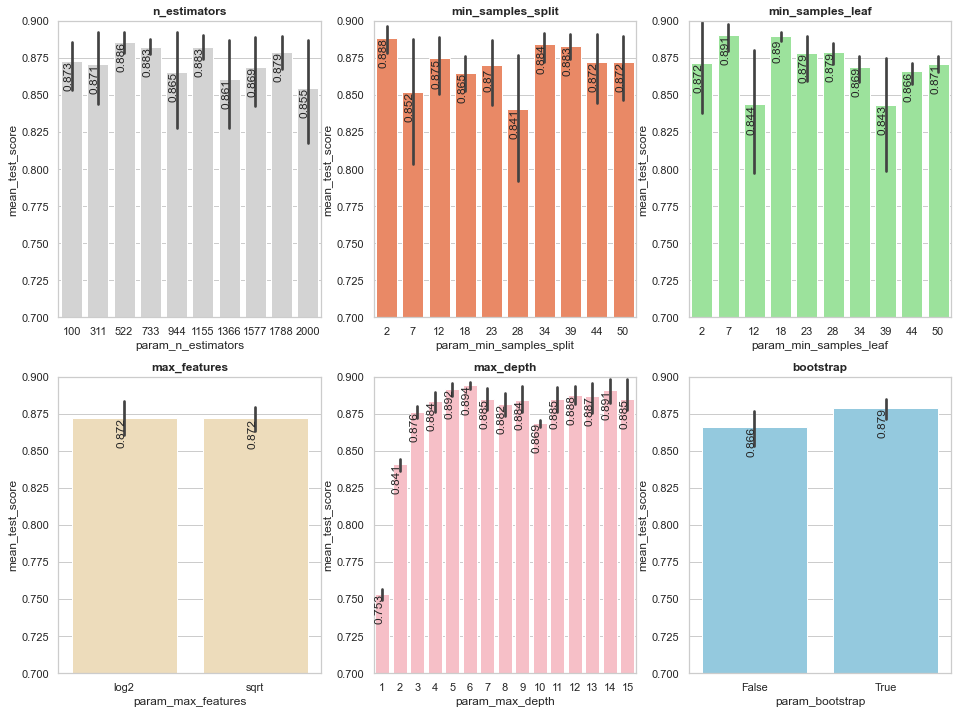

In [40]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 12))
sns.set(style="whitegrid", color_codes=True)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axes[0,0], color='lightgrey')
axes[0,0].set_ylim([.7,.9])
axes[0,0].set_title(label = 'n_estimators',  weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axes[0,1], color='coral')
axes[0,1].set_ylim([.7,.9])
axes[0,1].set_title(label = 'min_samples_split',  weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axes[0,2], color='lightgreen')
axes[0,2].set_ylim([.7,.9])
axes[0,2].set_title(label = 'min_samples_leaf',  weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axes[1,0], color='wheat')
axes[1,0].set_ylim([.7,.9])
axes[1,0].set_title(label = 'max_features',  weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axes[1,1], color='lightpink')
axes[1,1].set_ylim([.7,.9])
axes[1,1].set_title(label = 'max_depth',  weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axes[1,2], color='skyblue')
axes[1,2].set_ylim([.7,.9])
axes[1,2].set_title(label = 'bootstrap',  weight='bold')

for row in range(len(axes)):
    for col in range(len(axes[0])):
        _show_values_on_bars_rot(axes[row, col], -0.01, 3)
        ylim = .000001
        for p in axes[row, col].patches:
            if p.get_height() > ylim:
                ylim =  p.get_height()

plt.show()

---

Далее, используя алгоритм `GridSearchCV`, будем сравнивать модели с комбинациями ГП из определенного набора (из тех значений, при которых модель показывала наилучший результат).

In [41]:
# варианты значений ГП
n_estimators = [522,733,1155,1788]
min_samples_split = [2,34,39]
min_samples_leaf = [7,18]
max_features = ['log2']
max_depth = [5,6,14]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [42]:
# запустим алгоритм для построения моделей с различными комбинациями ГП
# и определения модели с лучшими параметрами
gs = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_val_st, y_val)

# модель с наилучшей комбинацией ГП
rfc_fin = gs.best_estimator_

# значения ГП в модели
gs.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.7min finished


{'bootstrap': True,
 'max_depth': 14,
 'max_features': 'log2',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 1788}

---

Сравним результаты работы 3-х моделей:
- LogisticRegression;
- RandomForestClassifier;
- RandomForestClassifier с измененными гиперпараметрами.

In [43]:
m1 = LogisticRegression(random_state=2)
m1.fit(X_train_st, y_train)
predictions=m1.predict(X_test_st)
print(m1)
print('\tAccuracy: {:.3f}'.format(accuracy_score(y_test, predictions)))
print('\tPrecision: {:.3f}'.format(precision_score(y_test, predictions)))
print('\tRecall: {:.3f}'.format(recall_score(y_test, predictions)))
print('\tF1: {:.3f}'.format(f1_score(y_test, predictions)))

m2 = RandomForestClassifier(random_state=2)
m2.fit(X_train_st, y_train)
predictions=m2.predict(X_test_st)
print(m2)
print('\tAccuracy: {:.3f}'.format(accuracy_score(y_test, predictions)))
print('\tPrecision: {:.3f}'.format(precision_score(y_test, predictions)))
print('\tRecall: {:.3f}'.format(recall_score(y_test, predictions)))
print('\tF1: {:.3f}'.format(f1_score(y_test, predictions)))

predictions = rfc_fin.predict(X_test_st)
print('Tuned', rfc_fin)
print('\tAccuracy: {:.3f}'.format(accuracy_score(y_test, predictions)))
print('\tPrecision: {:.3f}'.format(precision_score(y_test, predictions)))
print('\tRecall: {:.3f}'.format(recall_score(y_test, predictions)))
print('\tF1: {:.3f}'.format(f1_score(y_test, predictions)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
	Accuracy: 0.899
	Precision: 0.798
	Recall: 0.817
	F1: 0.808
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)
	Accuracy: 0.884
	Precision: 0.798
	Recall: 0.740
	F1: 0.768
Tuned RandomForestClassifier(bootstrap=True, class_weight=None, crite

Настройкой гиперпараметров удалось увеличить метрику Precision, но Recall сильно уменьшился.

---

Для определения наиболее важных признаков для прогноза оттока будем использовать модель логистической регрессии из-за наибольшей Accuracy и её интерпретируемости.

In [44]:
# весовые коэффициенты для признаков в логистической регрессии
m1.coef_

array([[-0.007396  , -0.1261061 , -0.05112662, -0.14525338, -0.07740181,
        -0.36405282, -1.06492012, -0.59062298, -1.19162723, -3.60313177,
        -0.65277839]])

In [45]:
# нулевой коэффициент в логистической регрессии
m1.intercept_

array([-3.35017623])

In [46]:
# создадим датафрейм с именами признаков и их важностью 
features = pd.DataFrame(m1.coef_[0], X.columns).reset_index()
features.columns=('feature','coeff')
features['coeff_abs'] = features['coeff'].abs()

# выведем упорядоченный по модулю коэффициентов датафрейм с признаками
print(features.round(3).sort_values(by = 'coeff_abs', ascending = False))

                         feature  coeff  coeff_abs
9                       Lifetime -3.603      3.603
8          Month_to_end_contract -1.192      1.192
6                            Age -1.065      1.065
10     Avg_class_frequency_total -0.653      0.653
7   Avg_additional_charges_total -0.591      0.591
5                   Group_visits -0.364      0.364
3                  Promo_friends -0.145      0.145
1                  Near_Location -0.126      0.126
4                          Phone -0.077      0.077
2                        Partner -0.051      0.051
0                         Gender -0.007      0.007


Согласно модели без учета сильно коррелирующих признаков, самыми важными признаками оттока посетителей являются:
- время с первого обращения в фитнес-центр;
- срок до окончания действия текущего абонемента;
- возраст.

<a id="4"></a>
### 4. Кластеризация посетителей  [*(Оглавление)*](#contents)


In [47]:
# отбросим столбец с целевой переменной
X = df.drop(columns = ['Churn'])

In [48]:
# стандартизуем данные (приводим к стандартному нормальному распределению)
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [49]:
# построим матрицу расстояний между объектами на стандартизованной матрице признаков
linked = linkage(X_sc, method = 'ward')

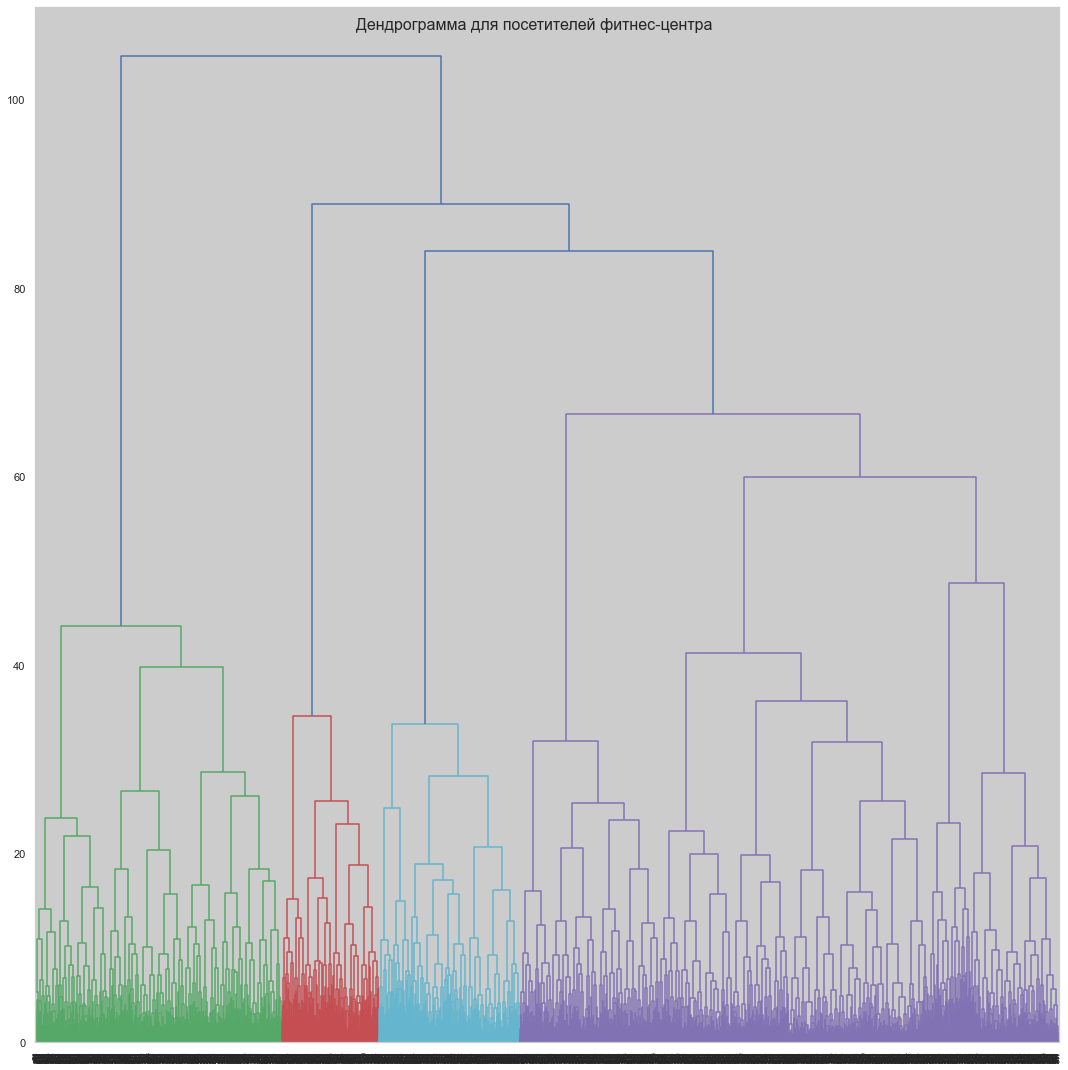

In [50]:
# построим дендрограмму
f, ax = plt.subplots(figsize=(15, 15)) 
dendrogram(linked, orientation='top')

f.suptitle('Дендрограмма для посетителей фитнес-центра', fontsize=16)
plt.tight_layout()
f.subplots_adjust(top=0.99)

Судя по дендрограмме, можем выделить 6 кластеров.

---

In [51]:
# зададим модель k_means с числом кластеров 6
km = KMeans(n_clusters = 6, random_state = 1)

# спрогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_sc)

# сохраним метки кластера в отдельный столбец датасета
df['cluster'] = labels

# выведем статистику по средним значениям признаков по кластеру
df.groupby('cluster').mean().round(2)

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
0,0.50,0.00,0.47,0.08,1.0,2.20,0.21,28.48,134.53,2.08,2.76,1.66,1.48,0.45
1,0.50,0.99,0.93,1.00,1.0,9.93,0.55,29.78,157.79,9.06,4.64,1.97,1.96,0.04
2,0.57,0.98,0.33,0.22,1.0,2.21,0.48,30.04,162.18,2.07,4.81,2.82,2.82,0.08
3,0.50,0.92,0.55,0.00,1.0,11.11,0.50,30.15,163.51,10.10,4.80,2.00,1.99,0.03
4,0.48,1.00,0.34,0.22,1.0,1.73,0.34,28.12,129.65,1.67,2.36,1.24,0.99,0.54
5,0.52,0.86,0.47,0.31,0.0,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27


- Распределение по полу, посещению групповых занятий, суммарной выручке от дополнительных услуг примерно одинаковое в каждом кластере.
- Выделен кластер 0 по признаку отсутствия близости фитнес центра к работе или дому.
- Выделен кластер 1 по признаку сотрудничества с компанией посетителя.
- Выделен кластер 1 по признаку рекомендации от знакомых.
- Выделен кластер 5 по признаку отсутствие контактного телефона.
- Выделены кластеры 1 и 3 по относительно большой длительности текущего абонемента.
- Выделены кластеры 1 и 3 по относительно большому сроку до конца действия текущего абонемента.
- Выделены кластеры 1, 2 и 3 по относительно большому сроку с момента первого обращения в фитнес-центр.
- Выделены кластеры 1, 2 и 3 по относительно большой средней частоте посещений в неделю (всего и за месяц).
- Посетители из кластеров 1, 2 и 3 более надежны.
- Посетители из кластеров 0, 4 и 5 более склонны к оттоку.


---

Рассмотрим подробнее признаки, характерные для каждого кластера.

In [52]:
# количество посетителей в каждом кластере
df['cluster'].value_counts()

4    1172
2     797
1     636
3     511
0     498
5     386
Name: cluster, dtype: int64

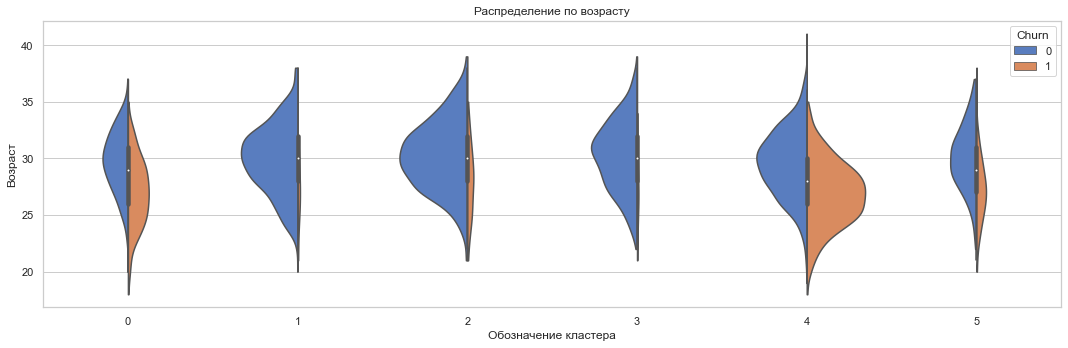

In [53]:
# построим распределение возраста посетителей каждого кластера с разделением на ушедших и оставшихся
f, ax = plt.subplots(figsize=(15, 5)) 
ax = sns.violinplot(x="cluster", y="Age", hue = 'Churn', data=df,
                    palette="muted", split=True, scale="count", cut = 0, scale_hue=False)
ax.set(xlabel = 'Обозначение кластера', 
       ylabel = 'Возраст', 
       title = 'Распределение по возрасту')
plt.tight_layout()

В кластерах 1, 2, 3 относительно мало ушедших посетителей, оставшиеся посетители этих кластеров в среднем на 3 года старше, чем в остальных кластерах.

---

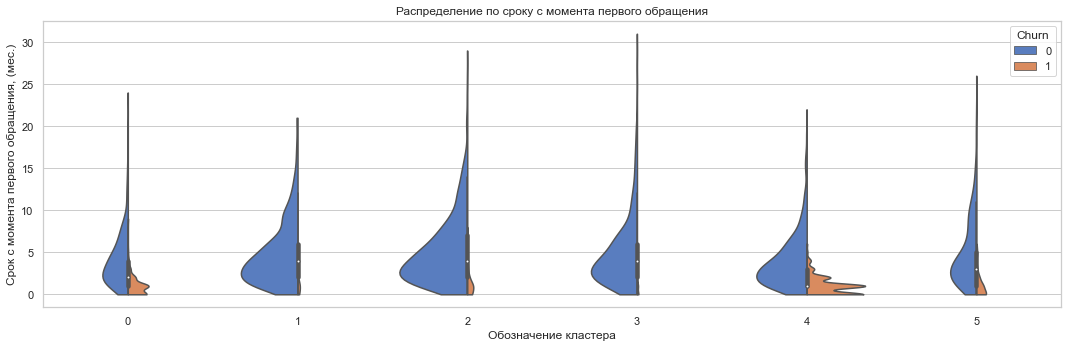

In [54]:
# построим распределение срока с момента первого обращения для  посетителей каждого кластера 
# с разделением на ушедших и оставшихся
f, ax = plt.subplots(figsize=(15, 5)) 
ax = sns.violinplot(x="cluster", y="Lifetime", hue = 'Churn', data=df, 
                    palette="muted", split=True, scale="count", cut = 0, scale_hue=False)

ax.set(xlabel = 'Обозначение кластера', 
       ylabel = 'Срок с момента первого обращения, (мес.)', 
       title = 'Распределение по сроку с момента первого обращения')
plt.tight_layout()

В кластерах 1, 2, 3 относительно мало ушедших посетителей, оставшиеся посетители этих кластеров в среднем на 1-2 месяца дольше взаимодействуют с фитнес-центром.

---

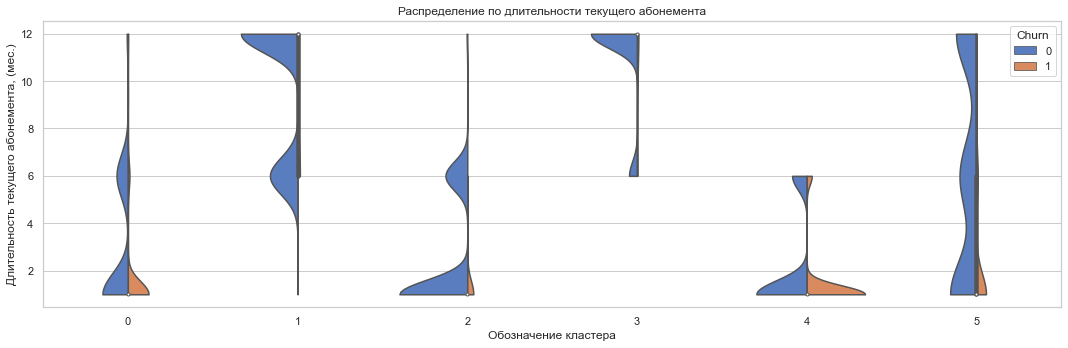

In [55]:
# построим распределение по длительности текущего абонемента для посетителей каждого кластера 
# с разделением на ушедших и оставшихся
f, ax = plt.subplots(figsize=(15, 5)) 
ax = sns.violinplot(x="cluster", y="Contract_period", hue = 'Churn', data=df, 
                    palette="muted", split=True, scale="count", cut = 0, scale_hue=False)

ax.set(xlabel = 'Обозначение кластера', 
       ylabel = 'Длительность текущего абонемента, (мес.)', 
       title = 'Распределение по длительности текущего абонемента')
plt.tight_layout()

В кластерах 2, 3, 5 относительно велико количество оставшихся посетителей с длительными абонементами. У подавляющего большинства ушедших пользователей абонемент был оформлен на 1 месяц.

---

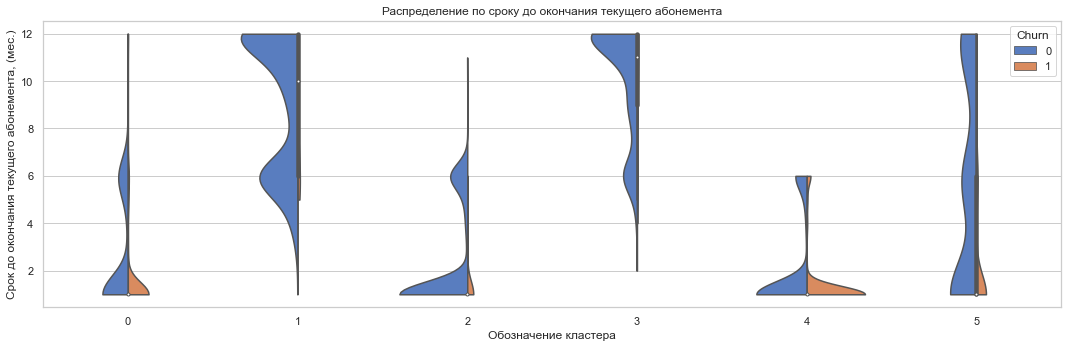

In [56]:
# построим распределение по сроку до окончания текущего абонемента для посетителей каждого кластера 
# с разделением на ушедших и оставшихся
f, ax = plt.subplots(figsize=(15, 5)) 
ax = sns.violinplot(x="cluster", y="Month_to_end_contract", hue = 'Churn', data=df, 
                    palette="muted", split=True, scale="count", cut = 0, scale_hue=False)

ax.set(xlabel = 'Обозначение кластера', 
       ylabel = 'Срок до окончания текущего абонемента, (мес.)', 
       title = 'Распределение по сроку до окончания текущего абонемента')
plt.tight_layout()

Распределение похоже на распределение по длительности абонемента.

---

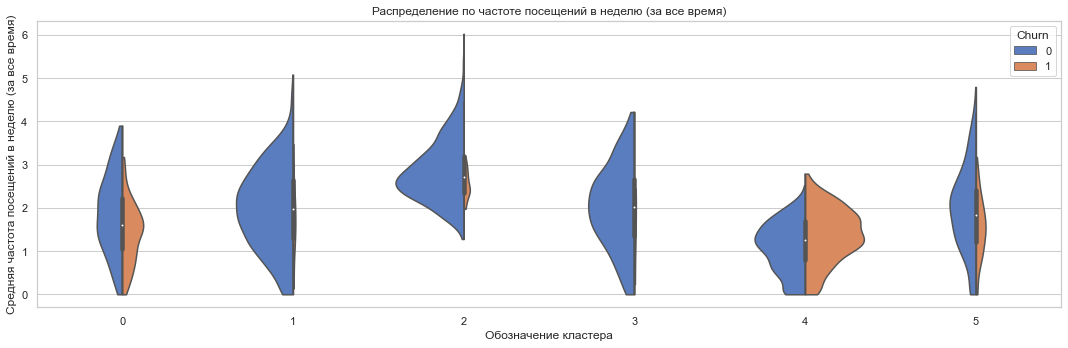

In [57]:
# построим распределение по средней частоте посещений (за всё время) для посетителей каждого кластера 
# с разделением на ушедших и оставшихся
f, ax = plt.subplots(figsize=(15, 5)) 
ax = sns.violinplot(x="cluster", y="Avg_class_frequency_total", hue = 'Churn', data=df, 
                    palette="muted", split=True, scale="count", cut = 0, scale_hue=False)

ax.set(xlabel = 'Обозначение кластера', 
       ylabel = 'Средняя частота посещений в неделю (за все время)', 
       title = 'Распределение по частоте посещений в неделю (за все время)')
plt.tight_layout()

Более надежные посетители (кластеры 1, 2, 3) занимаются 2 и более раз в неделю.

---

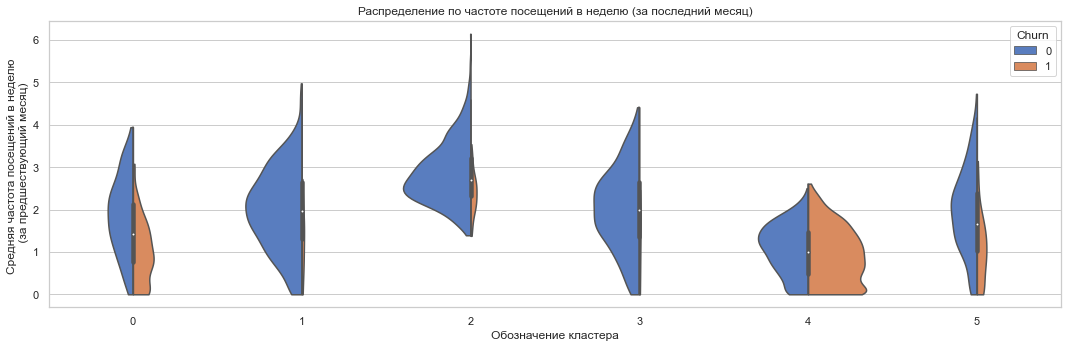

In [58]:
# построим распределение по средней частоте посещений (за предшествующий месяц) для посетителей каждого кластера 
# с разделением на ушедших и оставшихся
f, ax = plt.subplots(figsize=(15, 5)) 
ax = sns.violinplot(x="cluster", y="Avg_class_frequency_current_month", hue = 'Churn', data=df, 
                    palette="muted", split=True, scale="count", cut = 0, scale_hue=False)

ax.set(xlabel = 'Обозначение кластера', 
       ylabel = 'Средняя частота посещений в неделю \n (за предшествующий месяц)', 
       title = 'Распределение по частоте посещений в неделю (за последний месяц)')
plt.tight_layout()

Ушедшие пользователи в кластерах 0, 4 и 5 снизили частоту занятий в предшествующий уходу месяц.

---

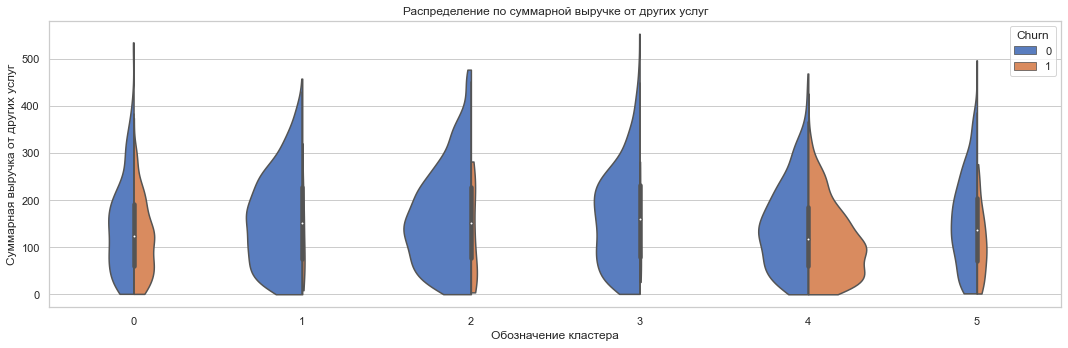

In [59]:
# построим распределение по суммарной выручке от других услуг для посетителей каждого кластера 
# с разделением на ушедших и оставшихся
f, ax = plt.subplots(figsize=(15, 5)) 
ax = sns.violinplot(x="cluster", y="Avg_additional_charges_total", hue = 'Churn', data=df, 
                    palette="muted", split=True, scale="count", cut = 0, scale_hue=False)

ax.set(xlabel = 'Обозначение кластера', 
       ylabel = 'Суммарная выручка от других услуг', 
       title = 'Распределение по суммарной выручке от других услуг')
plt.tight_layout()

В кластерах 1, 2, 3 суммарная выручка немного выше, чем в других кластерах, что может быть связано с их более длительным взаимодействием с фитнес-центром.

<a id="5"></a>
### 5. Выводы и рекомендации  [*(Оглавление)*](#contents)


1. Посетители уходят в первые месяцы взаимодействия с фитнес-центром.
2. Посетители, которые в итоге ушли, в месяц перед уходом занимались реже 1 раза в неделю.
3. Средний возраст ушедших посетителей в среднем на 3 года меньше чем у оставшихся.

Возможные рекомендации:
1. Изменить минимально возможную длительность действия абонемента, вместо 1 месяца установить 3 или 4.
2. Напоминать посетителям, которые начали заниматься реже (особенно реже 1 раза в неделю), о фитнес-центре.
3. Делать акцент на посетителях большего возраста (около 30 лет).